In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX

import data
kd = data.Kaya_data

估计CI

In [45]:
# 已知数据
GDP = kd["GDP"]
MTCO2e = kd["MTCO2e"]

# 计算总体CI (排除无效数据)
CI_values = [mtco2e * 1000000 / gdp for gdp, mtco2e in zip(GDP, MTCO2e) if gdp != -1 and mtco2e != -1]

# 计算均值和标准差
mean_CI = np.mean(CI_values)
std_CI = np.std(CI_values, ddof=1)  # 使用样本标准差

# 计算95%的置信区间
n = len(CI_values)
alpha = 0.05  # 95%置信区间
t_score = stats.t.ppf(1 - alpha / 2, df=n - 1)  # t分布临界值
margin_of_error = t_score * (std_CI / np.sqrt(n))

# 置信区间
CI_lower = mean_CI - margin_of_error
CI_upper = mean_CI + margin_of_error

mean_CI, CI_lower, CI_upper

(148.20508583451706, 143.02943666164063, 153.3807350073935)

In [46]:
# 经验公式算出每年的旅游收入
tourism_income = kd["Tourism_Numbers"]
tourism_income = [i * 632 for i in tourism_income]
# print(tourism_income)

预测ratio

[0.24054792545672665, 0.26019398723340303, 0.2737946404176605, 0.2863118858723009, 0.31912067114310166, 0.3774379771312354, 0.3910522376745409, 0.3636923725657948, 0.35653767522673135, 0.5283062058730631]


c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will 

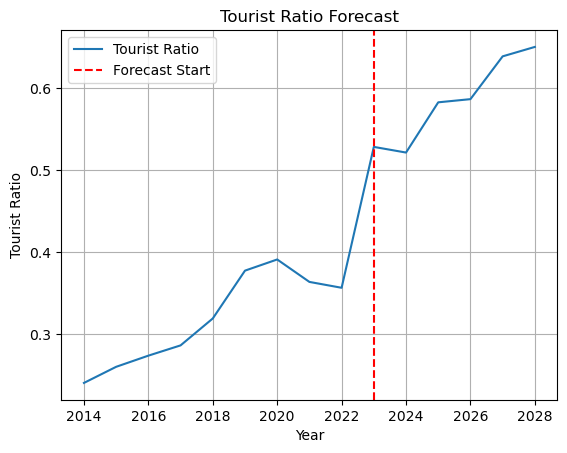

In [47]:
# # 旅游收入占GDP的比例
# tourism_income_ratio = [i / j for i, j in zip(tourism_income, GDP) if j != -1]
# print(tourism_income_ratio)

# # 线性预测后面的比例
# X = np.arange(2014, 2024).reshape(-1, 1)
# y = np.array(tourism_income_ratio).reshape(-1, 1)
# assert len(X) == len(y)

# lr_model = LinearRegression()
# lr_model.fit(X, y)

# X = np.arange(2014, 2029).reshape(-1, 1)
# tourism_income_ratio_pred = lr_model.predict(X)

# # 旅游收入预测
# # 画图
# plt.figure(figsize=(10, 6))
# plt.plot(X, tourism_income_ratio_pred, label="Tourism Income Ratio Prediction")
# plt.plot(np.arange(2014, 2024), tourism_income_ratio, label="Tourism Income Ratio")
# plt.legend()
# plt.xlabel("Year")
# plt.ylabel("Tourism Income Ratio")
# plt.title("Tourism Income Ratio Prediction")
# plt.show()

# # SARIMA模型预测
data = {
    "Year": [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "GDP": [2524869000, 2435418000, 2437578000, 2511152000, 2467392000, 2414435000, 2292657000, 2421944000, 2423728000, 2387533000],
    "Tourism_Numbers": [9.61e5, 9.83e5, 1.015e6, 1.072e6, 1.151e6, 1.306e6, 1.259667e6, 1.213333e6, 1.167e6, 1.67e6],
    "GDP": [2524869000, 2435418000, 2437578000, 2511152000, 2467392000, 2414435000, 2292657000, 2421944000, 2423728000, 2387533000]
}

tourism_number = data["Tourism_Numbers"]
# 人均旅游以2%的增长率增长，初始为632
tourism_spend = [632 * (1 + 0.02) ** i for i in range(20)]
tmp = tourism_spend[0:10]
assert len(tourism_number) == len(tmp)
tourism_income = [i * j for i, j in zip(tourism_number, tmp)]
GDP = data["GDP"]

tourism_income_ratio = [i / j for i, j in zip(tourism_income, GDP) if j != -1]

print(tourism_income_ratio)


df = pd.DataFrame(data)
df.set_index('Year', inplace=True)
df["Pande_Impact"] = [0, 0, 0, 0, 0, 0, 0.2, 1, 0.8, 0]
df["Tourist_Ratio"] = tourism_income_ratio

# 扩展预测年份到2030年
forecast_years = list(range(2024, 2029))
forecast_exog = np.zeros(len(forecast_years))  # 假设未来几年疫情影响因子为0

model0 = SARIMAX(df["Tourist_Ratio"], exog=df['Pande_Impact'], order=(1, 2, 2))
fitted_model0 = model0.fit()

forecast0 = fitted_model0.forecast(steps=len(forecast_years), exog=forecast_exog)

forecast_df0 = pd.DataFrame({

    'Year': forecast_years,
    'Tourist_Ratio': forecast0
})

forecast_df0.set_index('Year', inplace=True)

combined_df0 = pd.concat([df, forecast_df0])

plt.plot(combined_df0.index, combined_df0['Tourist_Ratio'], label='Tourist Ratio')
plt.axvline(x=2023, color='r', linestyle='--', label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Tourist Ratio')
plt.title('Tourist Ratio Forecast')
plt.legend()
plt.grid(True)
plt.show()

预测CI

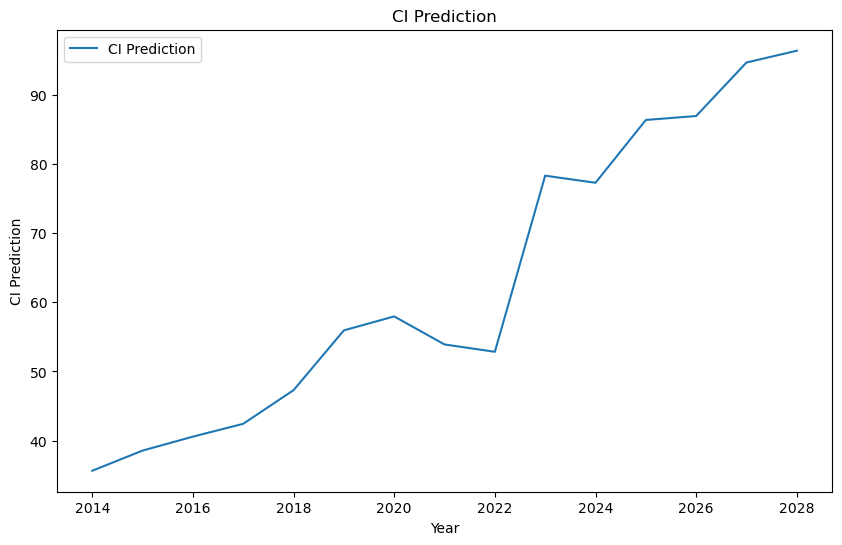

In [48]:
# 预测旅游的CI：用总的CI乘以预测的旅游收入比例
CI_pred = [mean_CI * i for i in combined_df0['Tourist_Ratio']]

CI_pred = [float(ci) for ci in CI_pred]
CI_pred

# 画图
plt.figure(figsize=(10, 6))
plt.plot(combined_df0.index, CI_pred, label="CI Prediction")
plt.xlabel("Year")
plt.ylabel("CI Prediction")
plt.title("CI Prediction")
plt.legend()
plt.show()


探究CI和旅游人数的关系

(15, 1) (15, 1)
方程：
CI =  [[5.81514161e-05]] * n +  [-18.40830941]
相关系数：
0.9915589379661329


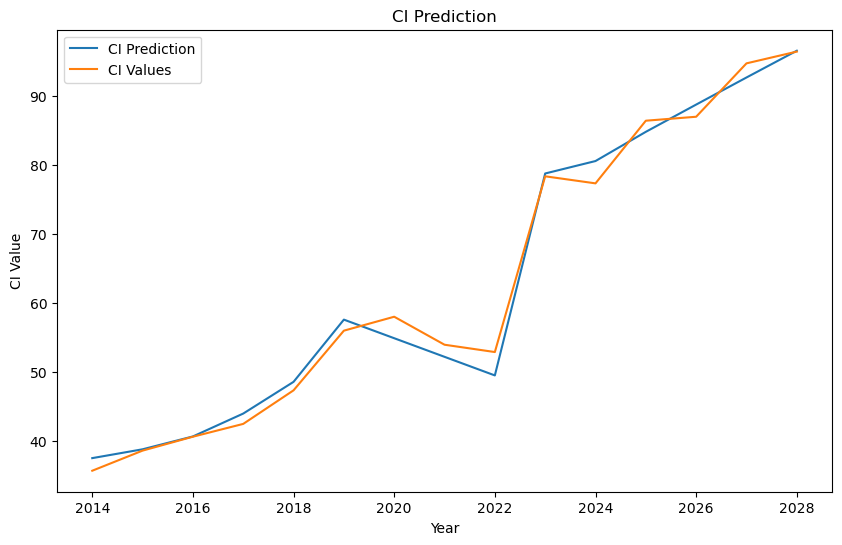

In [60]:
X = np.array(kd["Tourism_Numbers"]).reshape(-1, 1)
y = np.array(CI_pred).reshape(-1, 1)

print(X.shape, y.shape)
assert X.shape == y.shape

model_CI_num = LinearRegression()
model_CI_num.fit(X, y)

# 方程
print("方程：")
print("CI = ", model_CI_num.coef_, "* n + ", model_CI_num.intercept_)

# 相关系数
print("相关系数：")
r = model_CI_num.score(X, y)
print(r)

# 预测并画图
y_pred = model_CI_num.predict(X)

plt.figure(figsize=(10, 6))
plt.plot(kd["Year"], y_pred, label="CI Prediction")
plt.plot(kd["Year"], CI_pred, label="CI Values")
plt.xlabel("Year")
plt.ylabel("CI Value")
plt.title("CI Prediction")
plt.legend()
plt.show()

预测GDP

c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an 

               GDP  Tourism_Numbers  Pande_Impact  Tourist_Ratio
Year                                                            
2014  2.524869e+09         961000.0           0.0       0.240548
2015  2.435418e+09         983000.0           0.0       0.255092
2016  2.437578e+09        1015000.0           0.0       0.263163
2017  2.511152e+09        1072000.0           0.0       0.269798
2018  2.467392e+09        1151000.0           0.0       0.294818
2019  2.414435e+09        1306000.0           0.0       0.341857
2020  2.292657e+09        1259667.0           0.2       0.347243
2021  2.421944e+09        1213333.0           1.0       0.316616
2022  2.423728e+09        1167000.0           0.8       0.304301
2023  2.387533e+09        1670000.0           0.0       0.442063
2024  2.434566e+09              NaN           NaN            NaN
2025  2.524107e+09              NaN           NaN            NaN
2026  2.574512e+09              NaN           NaN            NaN
2027  2.660949e+09       

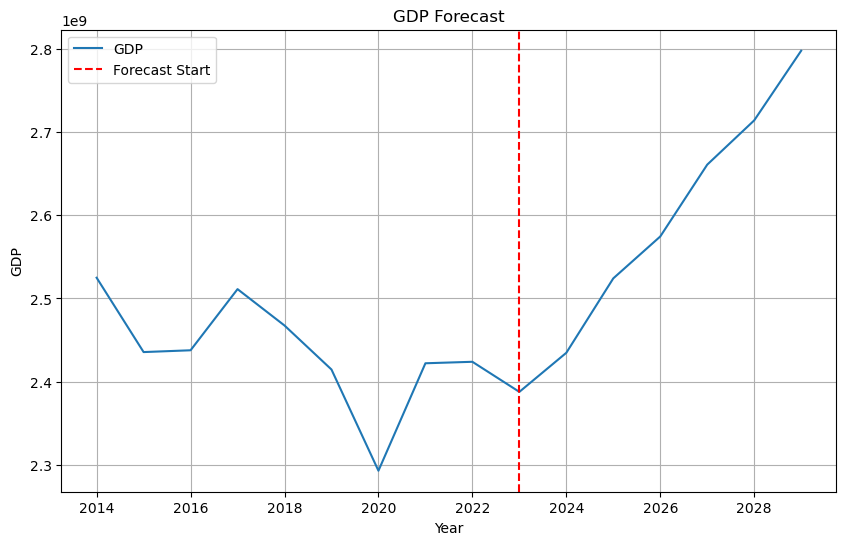

In [25]:
model = SARIMAX(df['GDP'], exog=df['Pande_Impact'], order=(1, 2, 2))
fitted_model = model.fit()



forecast = fitted_model.forecast(steps=len(forecast_years), exog=forecast_exog)

forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'GDP': forecast
})
forecast_df.set_index('Year', inplace=True)

# 合并已知数据和预测数据
combined_df = pd.concat([df, forecast_df])

print(combined_df)

combined_df.to_csv('combined_df.csv')

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(combined_df.index, combined_df['GDP'], label='GDP')
plt.axvline(x=2023, color='r', linestyle='--', label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('GDP Forecast')
plt.legend()
plt.grid(True)
plt.show()

kaya公式

[21652357495.285667, 23956918733.859787, 26029820319.95578, 28748444319.83745, 34404119367.59742, 46170965718.598305, 46139269362.91215, 41332758272.65959, 38972338851.317406, 82638489223.9821, 84175433699.41232, 98940044681.7465, 104755240976.63303, 119636420143.53772, 127744375451.58618]


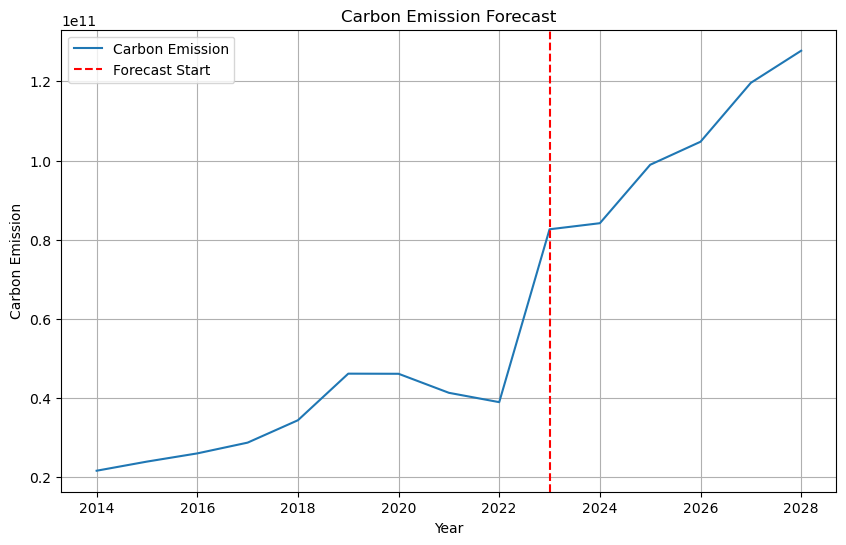

In [36]:
"""
碳排放量 = 旅游人数n * 旅游消费 * CI
        = 旅游人数n * 旅游消费 * model_CI_num(旅游人数n)
"""

C_tourism = [i * j * k for i, j, k in zip(kd["Tourism_Numbers"], tourism_spend, CI_pred)]
print(C_tourism)

# 绘制图像

plt.figure(figsize=(10, 6))
plt.plot(range(2014, 2029), C_tourism, label='Carbon Emission')
plt.axvline(x=2023, color='r', linestyle='--', label='Forecast Start')
plt.xlabel('Year')
plt.ylabel('Carbon Emission')
plt.title('Carbon Emission Forecast')
plt.legend()
plt.grid(True)
plt.show()
